In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.io import loadmat
import os

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

device

device(type='cuda', index=0)

In [2]:
!pip install tqdm

In [3]:
from tqdm.notebook import tqdm_notebook

### Load data

In [4]:
# Importing drive method from colab for accessing google drive
from google.colab import drive
import glob

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path = '/content/drive/My Drive/' #'/home/ab/Documents/DISK2TB/SaudiAramco/3D_geoproject/data/' 

In [6]:
tresh = 127
data3d = (loadmat(data_path+'Normal_1_0.5.mat')["ctImage"] > tresh).astype(np.float)

### Model

In [69]:
class FourierModel(torch.nn.Module):
    def __init__(self, sigma, inp_dim=2, out_dim=1, hid_dim=10, num_fc_layers=3, 
                 num_freq=10, activation=F.relu, device=device, rotate=False, cut_freq=None):
        super().__init__()
        self.num_freq = num_freq
        self.inp_dim = inp_dim
        self.out_dim = out_dim
        self.activation = activation
        sigmas = torch.pow(sigma, torch.arange(num_freq)/float(num_freq))
        #self.C_pos = torch.nn.Parameter(torch.rand(1,inp_dim*num_freq))
        if cut_freq is not None:
            if sigma > 1:
                sigmas = torch.pow(sigma, torch.arange(num_freq)/float(num_freq))
                self.sigmas = sigmas[:cut_freq].to(device)
            else:
                self.sigmas = sigmas[num_freq-cut_freq:].to(device)
        else:
            self.sigmas = sigmas.to(device)
        
        if cut_freq is None:
            self.num_freq = num_freq
        else:
            self.num_freq = cut_freq

        layers = [torch.nn.Linear(inp_dim * self.num_freq * 2, hid_dim)]
        layers.extend([torch.nn.Linear(hid_dim, hid_dim) for _ in range(num_fc_layers-2)])
        layers.append(torch.nn.Linear(hid_dim, out_dim))
        self.nn = torch.nn.ModuleList(layers)
        self.W_enc = torch.randn(inp_dim, inp_dim*self.num_freq)
        
        self.rotate=rotate
        if rotate:
            if self.inp_dim == 2:
                self.rot_mat = torch.Tensor([[1,1],[1,-1]]).to(device)
            else:
                raise ValueError('higher dimensions for this case are not supported yet')

    def pos_encoding(self, x):
        if self.rotate:
            x = x@self.rot_mat
        x = 2 * np.pi * torch.einsum('...,i -> ...i', x, self.sigmas)
        x = x.flatten(-2,-1)
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

    def gauss_encoding(self, x):
        x = x@self.W_enc
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
    
    def forward(self, x):
        x_enc = self.pos_encoding(x)
        for l in self.nn[:-1]:
            x_enc = l(x_enc)
            x_enc = self.activation(x_enc)
        x_enc = self.nn[-1](x_enc)
        return torch.sigmoid(x_enc)

In [70]:
md = FourierModel(sigma = 0.1, inp_dim=2, cut_freq=4)

In [71]:
md = md.to(device)

### Training on random points, 2D data

In [8]:
class DicreteDataset(Dataset):
    def __init__(self, shape):
        self.shape = shape

    def __len__(self):
        return np.prod(self.shape)

    def __getitem__(self, idx):
        indices = np.unravel_index(idx, self.shape)
        return indices


class PartialDataset(Dataset):
    def __init__(self, shape, mask):
        super().__init__()
        self.shape = shape
        self.mask = mask
        self.indices = np.arange(np.prod(shape))[mask.flatten()]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        indices = np.unravel_index(idx, self.shape)
        
        return indices

In [9]:
data = data3d[:,:,128]

Nx, Ny = data.shape
x = np.arange(Nx)
y = np.arange(Ny)

xx, yy = np.meshgrid(x, y)

N = np.prod(xx.shape)
N_train = int(0.3*N)

mask = np.zeros_like(data, dtype=np.bool)

points = np.random.choice(np.arange(N), size=N_train)
chosen_indices = np.unravel_index(points, xx.shape)
mask[chosen_indices] = 1
'''
Nx, Ny, Nz = data3d.shape
mask[Nx//2,:] = True
mask[Nx-1,:] = True
mask[0,:] = True
mask[:,Ny//2] = True
mask[:,Ny-1] = True
mask[:,0] = True
mask[:,:,Nz//2] = True
mask[:,:,Nz//2] = True
mask[:,:,Nz//2] = True
'''
ds_slices = PartialDataset(data.shape, mask)

In [ ]:
md = FourierModel(sigma=0.8, inp_dim=2, num_fc_layers=4, num_freq=10, hid_dim=100)
md = md.to(device)
torch_data = torch.from_numpy(data).to(device)

Text(0.5, 1.0, 'generated')

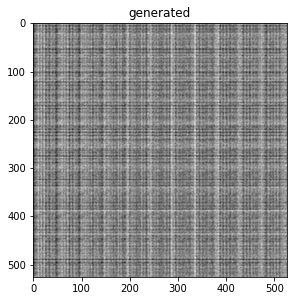

In [ ]:
Nx, Ny = data.shape
x = np.arange(Nx)
y = np.arange(Ny)

xx, yy = np.meshgrid(x, y)
idx_full = np.vstack([xx.flatten(), yy.flatten()]).T
res_torch = md(torch.Tensor(idx_full).float().to(device))
res = res_torch.data.cpu().numpy().reshape(xx.shape)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(res[:,:], cmap='gray')
plt.title('generated')

In [ ]:
list(range(100, 301, 100))

[100, 200, 300]

In [ ]:
#md = FourierModel(sigma=1., num_fc_layers=4, num_freq=10, hid_dim=256, activation=torch.nn.ReLU())
#md = md.to(device)
torch_data = torch.from_numpy(data).to(device)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds_slices),
    batch_size=2048,
    drop_last=False)

dl = DataLoader(ds_slices, sampler=sampler)
L = torch.nn.BCELoss()
#L = torch.nn.MSELoss()

n_epochs = 100
losses = []


optimizer = torch.optim.Adam(params=md.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(100,301, 100), gamma=0.1)

# optimizer = torch.optim.Adam(params=md.parameters(), lr=lr)

for epoch in tqdm_notebook(range(3*n_epochs)):
    for x in dl:
        optimizer.zero_grad()
        indices = torch.stack(x, dim=1).squeeze().T
        y_goal = torch_data[list(indices.T)]
        y_predicted = md(indices.float().to(device))
        loss = L(y_predicted.squeeze(-1), y_goal.float()) 
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach())
    scheduler.step()

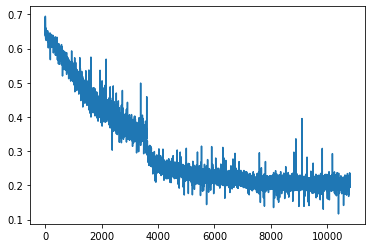

In [ ]:
plt.plot(losses)

In [ ]:
idx_full = np.concatenate([xx[:,:,None], yy[:,:,None]], axis=-1)
res_torch = md(torch.Tensor(idx_full).float().to(device))
res = res_torch.data.cpu().numpy().squeeze(-1) #.reshape(xx.shape)

Text(0.5, 1.0, 'real')

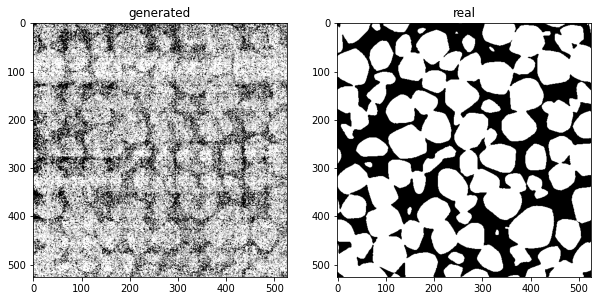

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(res.T[:, :], cmap='gray')
plt.title('generated')


plt.subplot(122)
plt.imshow(data[:, :], cmap='gray')
plt.title('real')

### Trying slices

In [30]:
num_freq = 30
sigma = 2.

ls = [np.power(1./sigma, float(i)/num_freq) for i in range(1,num_freq)]
ls

[0.9771599684342459,
 0.9548416039104165,
 0.9330329915368074,
 0.9117224885582168,
 0.8908987181403393,
 0.8705505632961241,
 0.8506671609508557,
 0.8312378961427878,
 0.8122523963562356,
 0.7937005259840998,
 0.7755723809168673,
 0.757858283255199,
 0.7405487761432821,
 0.7236346187201891,
 0.7071067811865476,
 0.690956439983888,
 0.675174973084095,
 0.6597539553864471,
 0.6446851542197896,
 0.6299605249474366,
 0.6155722066724582,
 0.6015125180410583,
 0.5877739531418044,
 0.5743491774985174,
 0.5612310241546865,
 0.548412489847313,
 0.5358867312681466,
 0.5236470614103134,
 0.5116869459983875]

In [ ]:
data3d.shape

(526, 526, 526)

In [191]:
data = data3d[::4,::4,128]

Nx, Ny = data.shape
x = np.arange(Nx)
y = np.arange(Ny)

xx, yy = np.meshgrid(x, y)

N = np.prod(xx.shape)

mask = np.zeros_like(data, dtype=np.bool)
'''
for i in range(10):
    mask[2**i, :] = True
    mask[:,2**i] = True
'''
'''
mask[2,:] = True
mask[6,:] = True
mask[15,:] = True
mask[39,:] = True
mask[4,:] = True
mask[12,:] = True
mask[30,:] = True
mask[78,:] = True
mask[8,:] = True
mask[24,:] = True
mask[::30,:] = True

#mask[156,:] = True
#mask[0,:] = True


mask[:, 2] = True
mask[:, 6] = True
mask[:, 15] = True
mask[:, 39] = True
mask[:, 4] = True
mask[:, 12] = True
mask[:, 30] = True
mask[:, 78] = True
mask[:, 0] = True
mask[:, 8] = True
mask[:, 24] = True
mask[:, ::30] = True
mask[:,120] = True
#mask[:, 156] = True
'''

selection = np.arange(Nx,step=20)[:,None]
selection_rand = selection+np.random.randint(7,size=(selection.shape[0], 2))
selection_rand[0] = selection[0]
selection_rand[-1] = selection[-1]

mask[selection_rand[:,0]] = True 
mask[:, selection_rand[:,1]] = True

#mask[Nx-1,:] = True
#mask[0,:] = True
#mask[np.arange(Nx), np.arange(Nx)] = True
#mask[np.arange(Nx), np.arange(Nx-1,-1,-1)] = True
#mask[:,Ny//2] = True
#mask[:,Ny-1] = True
#mask[:,0] = True


#mask[::32,:] = True
#mask[:,::32] = True

ds_slices = PartialDataset(data.shape, mask)

In [121]:
mask.shape

(132, 132)

In [113]:
mask.sum()

12240

In [ ]:
mask.sum()

4199

In [12]:
def train(model, dataloader, data, L, n_epochs=100):
    losses = []
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(100,301, 100), gamma=0.1)

    # optimizer = torch.optim.Adam(params=md.parameters(), lr=lr)

    for epoch in tqdm_notebook(range(3*n_epochs)):
        for x in dataloader:
            optimizer.zero_grad()
            indices = torch.stack(x, dim=1).squeeze().T
            y_goal = data[list(indices.T)]
            y_predicted = model(indices.float().to(device))
            loss = L(y_predicted.squeeze(-1), y_goal.float()) 
            loss.backward(retain_graph=True)
            optimizer.step()
            losses.append(loss.detach())
        scheduler.step()
    return losses

In [13]:
md_1 = FourierModel(sigma=sigma, inp_dim=2, num_fc_layers=4, num_freq=num_freq, hid_dim=100)
md_1 = md_1.to(device)
torch_data = torch.from_numpy(data).to(device)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds_slices),
    batch_size=2048,
    drop_last=False)

dl = DataLoader(ds_slices, sampler=sampler)
L = torch.nn.BCELoss()
#L = torch.nn.MSELoss()

n_epochs = 100
losses = train(md_1, dl, torch_data, L)


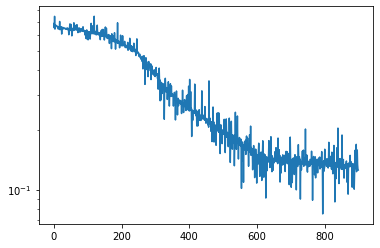

In [14]:
plt.semilogy(losses)

In [15]:
idx_full = np.concatenate([xx[:,:,None], yy[:,:,None]], axis=-1)
res_torch = md_1(torch.Tensor(idx_full).float().to(device))
res = res_torch.data.cpu().numpy().squeeze(-1) #.reshape(xx.shape)

Text(0.5, 1.0, 'real')

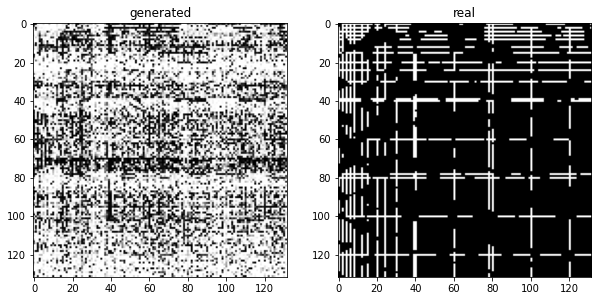

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(res.T[:, :], cmap='gray')
plt.title('generated')


plt.subplot(122)
plt.imshow(data[:, :]*mask, cmap='gray')
plt.title('real')

In [ ]:
x = torch.zeros((3,2), device=device)
md_1.pos_encoding(x).shape

torch.Size([3, 4])

In [195]:
# without rotation:
md_1 = FourierModel(sigma=2., inp_dim=2, num_fc_layers=4, num_freq=100, 
                    hid_dim=100, rotate=True, cut_freq=10)
md_1 = md_1.to(device)
torch_data = torch.from_numpy(data).to(device)

sampler = torch.utils.data.sampler.BatchSampler(
    torch.utils.data.sampler.RandomSampler(ds_slices),
    batch_size=2048,
    drop_last=False)

dl = DataLoader(ds_slices, sampler=sampler)
L = torch.nn.BCELoss()
#L = torch.nn.MSELoss()

n_epochs = 100
losses = train(md_1, dl, torch_data, L)


Text(0.5, 1.0, 'real')

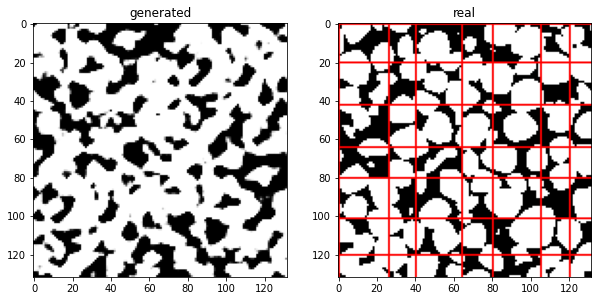

In [196]:
# рандомные срезы
idx_full = np.concatenate([xx[:,:,None], yy[:,:,None]], axis=-1)
res_torch = md_1(torch.Tensor(idx_full).float().to(device))
res = res_torch.data.cpu().numpy().squeeze(-1) #.reshape(xx.shape)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(res.T[:, :], cmap='gray')
plt.title('generated')


new_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=int)
new_mask[mask] = np.array([254,0,0])
masked_data = new_mask.copy()
data_rgb = np.zeros((data.shape[0],data.shape[1],3),dtype=int)
data_rgb[data==1,:] = np.array([255,255,255])
masked_data[new_mask[:,:,0] == 0] = data_rgb[new_mask[:,:,0] == 0]


plt.subplot(122)
plt.imshow(masked_data, cmap='gray')
plt.title('real')


Text(0.5, 1.0, 'real')

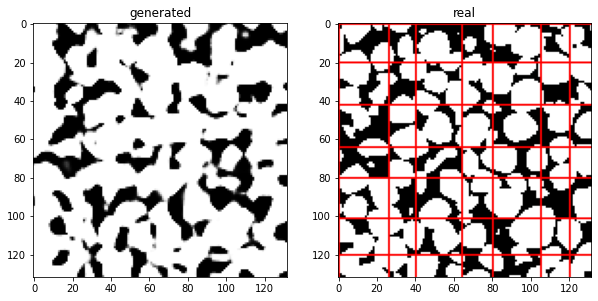

In [192]:
    # каждый пятый срез
idx_full = np.concatenate([xx[:,:,None], yy[:,:,None]], axis=-1)
res_torch = md_1(torch.Tensor(idx_full).float().to(device))
res = res_torch.data.cpu().numpy().squeeze(-1) #.reshape(xx.shape)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(res.T[:, :], cmap='gray')
plt.title('generated')


new_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=int)
new_mask[mask] = np.array([254,0,0])
masked_data = new_mask.copy()
data_rgb = np.zeros((data.shape[0],data.shape[1],3),dtype=int)
data_rgb[data==1,:] = np.array([255,255,255])
masked_data[new_mask[:,:,0] == 0] = data_rgb[new_mask[:,:,0] == 0]


plt.subplot(122)
plt.imshow(masked_data, cmap='gray')
plt.title('real')

In [168]:
data_rgb[new_mask[:,:,0] == 0].shape

(0, 3)

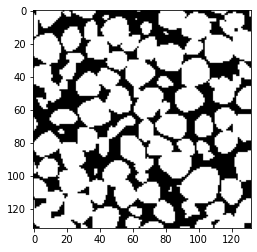

In [166]:
data_rgb = np.zeros((data.shape[0],data.shape[1],3),dtype=int)
data_rgb[data==1,:] = np.array([255,255,255])
plt.imshow(data_rgb)

In [163]:
data_rgb = np.zeros((data.shape[0],data.shape[1],3),dtype=int)
data_rgb[data==0,:].shape

(5988, 3)

In [160]:
data[new_mask[:,:,0] == 254].shape

(3500,)

Text(0.5, 1.0, 'real')

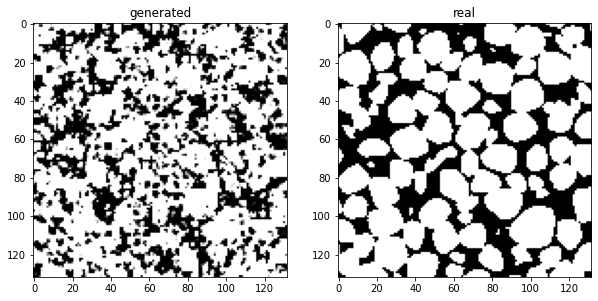

In [115]:
idx_full = np.concatenate([xx[:,:,None], yy[:,:,None]], axis=-1)
res_torch = md_1(torch.Tensor(idx_full).float().to(device))
res = res_torch.data.cpu().numpy().squeeze(-1) #.reshape(xx.shape)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(res.T[:, :], cmap='gray')
plt.title('generated')

plt.subplot(122)
plt.imshow(data[:, :], cmap='gray')
plt.title('real')

In [98]:
from scipy.signal import medfilt2d

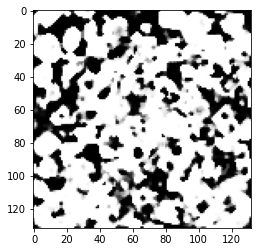

In [99]:
plt.imshow(medfilt2d(res.T, kernel_size=3),cmap='gray')

# 3D experiments